# Locust Swarming ODE Model

This notebook implements a simple ODE-based model of locust collective motion.  

Each locust has:
- Position $(x, y)$
- Heading angle $\theta$
- Activity $a \in [0,1]$ (paused vs. moving)

**Rules:**
- Locusts align with their neighbors (within radius $R$) at rate $\kappa$.
- Activity relaxes toward a sigmoid of neighbor count:
  $$
  \frac{da_i}{dt} = -\frac{1}{\tau_a}\Big(a_i - \sigma(\beta_0 + \beta_1 n_i)\Big)
  $$
- Velocity interpolates between $v_{\min}$ and $v_{\max}$ depending on activity:
  $$
  v_i = v_{\min} + (v_{\max} - v_{\min})a_i
  $$
- Random noise perturbs headings:
  $$
  \frac{d\theta_i}{dt} = \kappa \cdot \langle \sin(\theta_j - \theta_i)\rangle + \sqrt{2\eta}\,\xi
  $$
- Periodic boundary conditions are applied in a square domain of side length \(L\).


In [48]:
# === Imports ===
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from math import pi

## Parameters

We separate mathematical parameters (biological meaning) from computational parameters (simulation control).


In [49]:
@dataclass
class MathParams:
    N: int = 120        # Number of locusts [count]
    L: float = 10.0     # Domain size [m]
    v_min: float = 0.01 # Minimum speed [m/s]
    v_max: float = 0.15 # Maximum speed [m/s]
    kappa: float = 2.0  # Alignment strength [1/s]
    R: float = 1.0      # Vision radius [m]
    eta: float = 0.4    # Noise intensity [rad/s^0.5]
    beta0: float = -1.0 # Baseline activity bias [—]
    beta1: float = 0.25 # Social activation gain [—]
    tau_a: float = 0.5  # Relaxation time [s]

@dataclass
class CompParams:
    dt: float = 0.05    # Time step [s]
    T: float = 100.0    # Total simulation time [s]
    seed: int = 42      # Random seed


## Helper functions


In [50]:
def wrap_positions(pos, L):
    pos[:, 0] %= L
    pos[:, 1] %= L

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def polarization(theta):
    vx, vy = np.cos(theta).mean(), np.sin(theta).mean()
    return np.sqrt(vx**2 + vy**2)


## Simulation Function


In [51]:
def simulate(math: MathParams, comp: CompParams):
    rng = np.random.default_rng(comp.seed)
    N, L = math.N, math.L
    dt, steps = comp.dt, int(comp.T / comp.dt)

    # Initial state
    pos = rng.uniform(0, L, size=(N, 2))
    theta = rng.uniform(-pi, pi, size=N)
    a = rng.uniform(0, 1, size=N)

    time, pols, acts = [], [], []

    for t in range(steps):
        # Distances with periodic wrap
        dx = pos[:, None, 0] - pos[None, :, 0]
        dy = pos[:, None, 1] - pos[None, :, 1]
        dx -= np.round(dx / L) * L
        dy -= np.round(dy / L) * L
        dist2 = dx**2 + dy**2

        mask = (dist2 < math.R**2) & (dist2 > 0)
        nbh_counts = mask.sum(axis=1)

        # Heading update
        align_term = np.zeros(N)
        for i in range(N):
            if nbh_counts[i] > 0:
                align_term[i] = (
                    math.kappa / nbh_counts[i] *
                    np.sum(np.sin(theta[mask[i]] - theta[i]))
                )
        theta += dt * align_term + np.sqrt(2 * math.eta * dt) * rng.normal(size=N)

        # Activity update
        a_inf = sigmoid(math.beta0 + math.beta1 * nbh_counts)
        a += dt * (-(a - a_inf) / math.tau_a)
        a = np.clip(a, 0, 1)

        # Position update
        speed = math.v_min + (math.v_max - math.v_min) * a
        pos[:, 0] += dt * speed * np.cos(theta)
        pos[:, 1] += dt * speed * np.sin(theta)
        wrap_positions(pos, L)

        # Record
        if t % 5 == 0:
            time.append(t * dt)
            pols.append(polarization(theta))
            acts.append(a.mean())

    return {
        "time": np.array(time),
        "polarization": np.array(pols),
        "activity": np.array(acts),
    }


## Run a baseline simulation


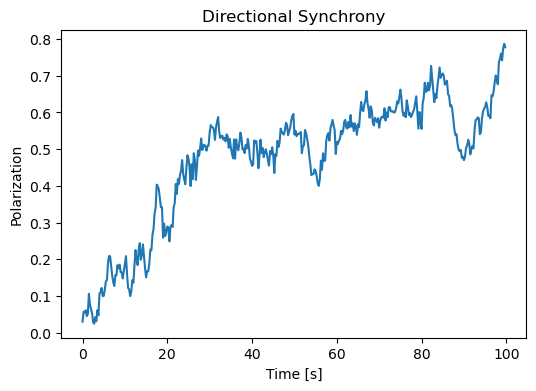

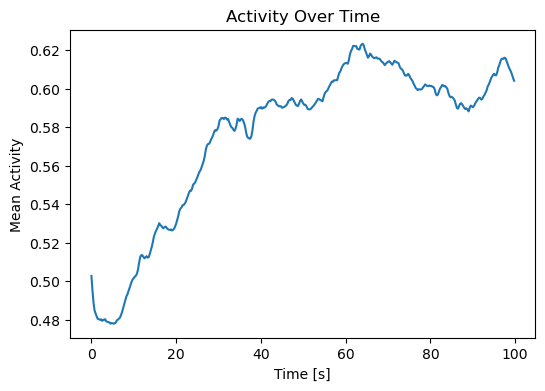

In [52]:
mp = MathParams()
cp = CompParams()

ts = simulate(mp, cp)

# Plot polarization
plt.figure(figsize=(6,4))
plt.plot(ts["time"], ts["polarization"])
plt.xlabel("Time [s]")
plt.ylabel("Polarization")
plt.title("Directional Synchrony")
plt.show()

# Plot mean activity
plt.figure(figsize=(6,4))
plt.plot(ts["time"], ts["activity"])
plt.xlabel("Time [s]")
plt.ylabel("Mean Activity")
plt.title("Activity Over Time")
plt.show()
